In [1]:
import pandas as pd
from helpers import most_common_words



In [2]:
# If there isn't header and le separator and decimal aren't , and .
# data = pd.read_csv("code/analyse/operations.csv", parse_dates=[1],                                  dayfirst=True, sep=";" decimal=",", header=None)

# Defining the columns with date data.
data = pd.read_csv("code/analyse/operations.csv", parse_dates=[1, 2],                                  dayfirst=True)
print(data)

     identifiant_transaction date_operation date_valeur  \
0                        242     2023-10-06  2023-10-06   
1                         25     2023-10-06  2023-10-06   
2                         69     2023-10-06  2023-10-06   
3                        299     2023-10-05  2023-10-05   
4                         45     2023-10-05  2023-10-05   
..                       ...            ...         ...   
303                      295     2023-04-03  2023-04-03   
304                      221     2023-04-03  2023-04-03   
305                      205     2023-04-03  2023-04-03   
306                       50     2023-04-03  2023-04-03   
307                      108     2023-03-31  2023-03-31   

                                          libelle  debit  credit    solde  
0            FORFAIT COMPTE SUPERBANK XX XX XX XX  -1.92     NaN  2513.79  
1                         CARTE XX XX CHEZ LUC XX -10.00     NaN  2529.29  
2                  PRELEVEMENT XX TELEPHONE XX XX -13.58     Na

In [3]:
most_common_words(data["libelle"].values)

('XX', 1428)
('CARTE', 247)
('VIREMENT', 29)
('LES', 20)
('ANCIENS', 20)
('ROBINSON', 20)
('CHEZ', 16)
('LUC', 16)
('LA', 16)
("L'EPICERIE", 16)
('DEMBAS', 16)
('TOUPTIPRI', 12)
('CCNCF', 9)
('RETRAIT', 9)
('PRELEVEMENT', 8)
('RAPT', 8)
('FORFAIT', 7)
('COMPTE', 7)
('SUPERBANK', 7)
('TELEPHONE', 7)
('DON', 7)
('LOUVE', 7)
('PERMANENT', 6)
('LOYER', 6)
('VELOC', 4)


In [4]:
CATEGS = {
    'LOYER': 'LOYER',
    'FORFAIT COMPTE SUPERBANK': 'COTISATION BANCAIRE',
    'LES ANCIENS ROBINSON': 'COURSES',
    "L'EPICERIE DENBAS": 'COURSES',
    'TELEPHONE': 'FACTURE TELEPHONE',
    'LA CCNCF': 'TRANSPORT',
    'CHEZ LUC': 'RESTAURANT',
    'RAPT': 'TRANSPORT',
    'TOUPTIPRI': 'COURSES',
    'LA LOUVE': 'COURSES',
    'VELOC': 'TRANSPORT'
}
TYPES = {
    'CARTE': 'CARTE',
    'VIR': 'VIREMENT',
    'VIREMENT': 'VIREMENT',
    'RETRAIT': 'RETRAIT',
    'PRLV': 'PRELEVEMENT',
    'DON': 'DON',
}

In [5]:
EXPENSES = [80,200] # Bornes des catégories de dépense : petite, moyenne et grosse
LAST_BALANCE = 2400 # Solde du compte APRES la dernière opération en date
WEEKEND = ["Saturday","Sunday"] # Jours non travaillés

In [6]:
# Controle des colonnes
for c in ['date_operation','libelle','debit','credit']:
    if c not in data.columns:
        if (c in ['debit','credit'] and 'montant' not in data.columns) or \
        (c not in ['debit','credit']):
            msg = "Il vous manque la colonne '{}'. Attention aux majuscules "
            msg += "et minuscules dans le nom des colonnes!"
            raise Exception(msg.format(c))

# Suppression des colonnes innutiles
for c in data.columns:
    if c not in ['date_operation','libelle','debit','credit','montant']:
        del data[c]

# Ajout de la colonne 'montant' si besoin
if 'montant' not in data.columns:
    data["debit"] = data["debit"].fillna(0)
    data["credit"] = data["credit"].fillna(0)
    data["montant"] = data["debit"] + data["credit"]
    del data["credit"], data["debit"]

In [7]:
print(data)

    date_operation                                       libelle  montant
0       2023-10-06          FORFAIT COMPTE SUPERBANK XX XX XX XX    -1.92
1       2023-10-06                       CARTE XX XX CHEZ LUC XX   -10.00
2       2023-10-06                PRELEVEMENT XX TELEPHONE XX XX   -13.58
3       2023-10-05                       CARTE XX XX XX XX XX XX   -10.64
4       2023-10-05                             CARTE XX XX XX XX    -4.80
..             ...                                           ...      ...
303     2023-04-03                           CARTE XX XX RAPT XX   -73.00
304     2023-04-03  VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX   676.00
305     2023-04-03                    VIREMENT XX XX XX XX XX XX     4.80
306     2023-04-03                             CARTE XX XX XX XX   -14.39
307     2023-03-31                      DON XX XX XX XX XX XX XX    -1.44

[308 rows x 3 columns]


In [8]:
# creation de la variable 'solde_avt_ope'
data = data.sort_values("date_operation")
amount = data["montant"]
balance = amount.cumsum()
balance = list(balance.values)
last_val = balance[-1]
balance = [0] + balance[:-1]
balance = balance - last_val + LAST_BALANCE
data["solde_avt_ope"] = balance

# Assignation des operations a une categorie et a un type
def detect_words(values, dictionary):
    result = []
    for lib in values:
        operation_type = "AUTRE"
        for word, val in dictionary.items():
            if word in lib:
                operation_type = val
        result.append(operation_type)
    return result
data["categ"] = detect_words(data["libelle"], CATEGS)
data["type"] = detect_words(data["libelle"], TYPES)

# creation des variables 'tranche_depense' et 'sens'
def expense_slice(value):
    value = -value # Les dépenses sont des nombres négatifs
    if value < 0:
        return "(pas une dépense)"
    elif value < EXPENSES[0]:
        return "petite"
    elif value < EXPENSES[1]:
        return "moyenne"
    else:
        return "grosse"
data["tranche_depense"] = data["montant"].map(expense_slice)
data["sens"] = ["credit" if m > 0 else "debit" for m in data["montant"]]

# Creation des autres variables
data["annee"] = data["date_operation"].map(lambda d: d.year)
data["mois"] = data["date_operation"].map(lambda d: d.month)
data["jour"] = data["date_operation"].map(lambda d: d.day)
data["jour_sem"] = data["date_operation"].map(lambda d: d.day_name)
data["jour_sem_num"] = data["date_operation"].map(lambda d: d.weekday()+1)
data["weekend"] = data["jour_sem"].isin(WEEKEND)
data["quart_mois"] = [int((jour-1)*4/31)+1 for jour in data["jour"]]
        
# Enregistrement au format CSV
data.to_csv("operations_enrichies.csv",index=False)

In [9]:
print(data)

    date_operation                               libelle  montant  \
307     2023-03-31              DON XX XX XX XX XX XX XX    -1.44   
302     2023-04-03                   CARTE XX XX RAPT XX   -24.00   
303     2023-04-03                   CARTE XX XX RAPT XX   -73.00   
306     2023-04-03                     CARTE XX XX XX XX   -14.39   
305     2023-04-03            VIREMENT XX XX XX XX XX XX     4.80   
..             ...                                   ...      ...   
4       2023-10-05                     CARTE XX XX XX XX    -4.80   
3       2023-10-05               CARTE XX XX XX XX XX XX   -10.64   
2       2023-10-06        PRELEVEMENT XX TELEPHONE XX XX   -13.58   
1       2023-10-06               CARTE XX XX CHEZ LUC XX   -10.00   
0       2023-10-06  FORFAIT COMPTE SUPERBANK XX XX XX XX    -1.92   

     solde_avt_ope                categ      type    tranche_depense    sens  \
307        1515.25                AUTRE       DON             petite   debit   
302        

In [10]:
data.head()

,date_operation,libelle,montant,solde_avt_ope,categ,type,tranche_depense,sens,annee,mois,jour,jour_sem,jour_sem_num,weekend,quart_mois
307,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE,DON,petite,debit,2023,3,31,<built-in method day_name of Timestamp object ...,5,False,4
302,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT,CARTE,petite,debit,2023,4,3,<built-in method day_name of Timestamp object ...,1,False,1
303,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT,CARTE,petite,debit,2023,4,3,<built-in method day_name of Timestamp object ...,1,False,1
306,2023-04-03,CARTE XX XX XX XX,-14.39,1416.81,AUTRE,CARTE,petite,debit,2023,4,3,<built-in method day_name of Timestamp object ...,1,False,1
305,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,1402.42,AUTRE,VIREMENT,(pas une dépense),credit,2023,4,3,<built-in method day_name of Timestamp object ...,1,False,1


In [11]:
import matplotlib.pyplot as plt



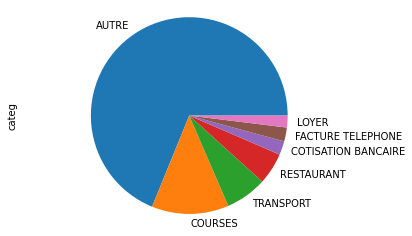

In [12]:
# VARIABLE QUALITATIVE
# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique



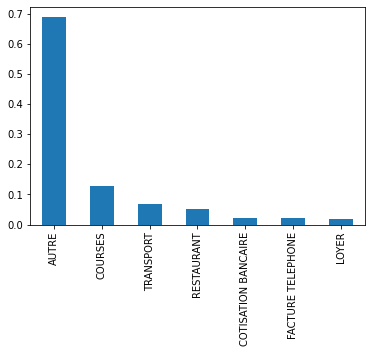

In [13]:
# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind='bar')
plt.show()



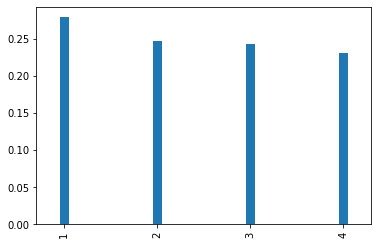

In [14]:
# VARIABLE QUANTITATIVE
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()



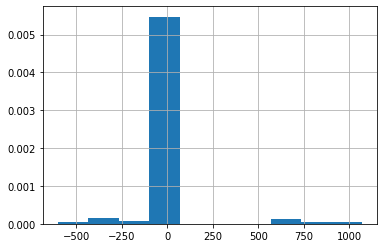

In [15]:
# Histogramme
data["montant"].hist(density=True)
plt.show()


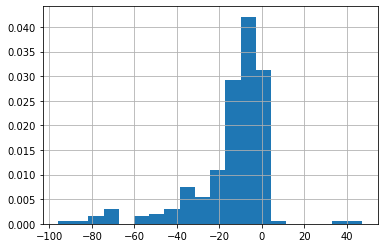

In [16]:
# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()

In [17]:
# count the repetitions of each value in the column
data["quart_mois"].value_counts()

1    86
2    76
3    75
4    71
Name: quart_mois, dtype: int64

In [20]:
effectifs = data["quart_mois"].value_counts()
modalites = effectifs.index effectifs = data["quart_mois"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités


In [28]:
tab = pd.DataFrame(modalites, columns=["quart_mois"]) # création du tableau à partir des modalités

In [29]:
tab

,quart_mois
0,1
1,2
2,3
3,4


In [23]:
tab["n"] = effectifs.values

In [24]:
tab

,guart_mois,n
0,1,86
1,2,76
2,3,75
3,4,71


In [25]:
tab["f"] = tab["n"] / len(data) # len(data) renvoie la taille de l'échantillon. Calcular la frecuencia

In [26]:
tab

,guart_mois,n,f
0,1,86,0.279221
1,2,76,0.246753
2,3,75,0.243506
3,4,71,0.230519


In [36]:
tab = tab.sort_values("quart_mois") # tri des valeurs de la variable X (croissant)
tab["F"] = tab["f"].cumsum() # cumsum calcule la somme cumulée
tab

,quart_mois,n,f,F
0,1,86,0.279221,0.279221
1,2,76,0.246753,0.525974
2,3,75,0.243506,0.769481
3,4,71,0.230519,1.000000
